In [34]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm

## Load the data:

In [35]:
# Set the file path:
path = "results/"
file_name = "result_PolyHoot_ST_1_dc6a9e2d-d305-4f5f-884b-3ed725501e3c.jsonl"

In [36]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [37]:
df = parse_results(path + file_name)

In [38]:
df.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules
0,ea38597d-80a4-47c8-ae2f-ee19b59f6466,28497.684613,26608,46.707743,40.157584,2.702088,56967,1.722905,NaN,NaN,NaN
1,089b781b-e293-4dac-a939-b5f11880ac24,24805.893678,18750,37.810805,31.564191,2.992555,49589,0.504361,0.25,10.0,2.0
2,278dc6be-8616-4e32-8a16-3a0f991c8dc9,30390.370217,31005,51.037037,44.848912,2.611830,60750,0.591057,0.75,10.0,2.0
3,20c8c119-0264-45e2-b3d4-b6805d78f0ec,18653.332586,6577,17.634599,15.138502,2.833610,37296,0.422060,0.25,5.0,2.0
4,6647202d-d6ad-443b-a7e8-272cb6657c1f,25860.620096,20826,40.284736,33.853225,3.000756,51697,0.346750,0.25,15.0,2.0


### Get the configuration file from these results

In [39]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config



In [40]:
configuration = get_config(file_name)

# Example scripts for plots & Graphs

## SETUP CUSTOM STYLING FOR THE PLOTS

**plot the score / itterations**

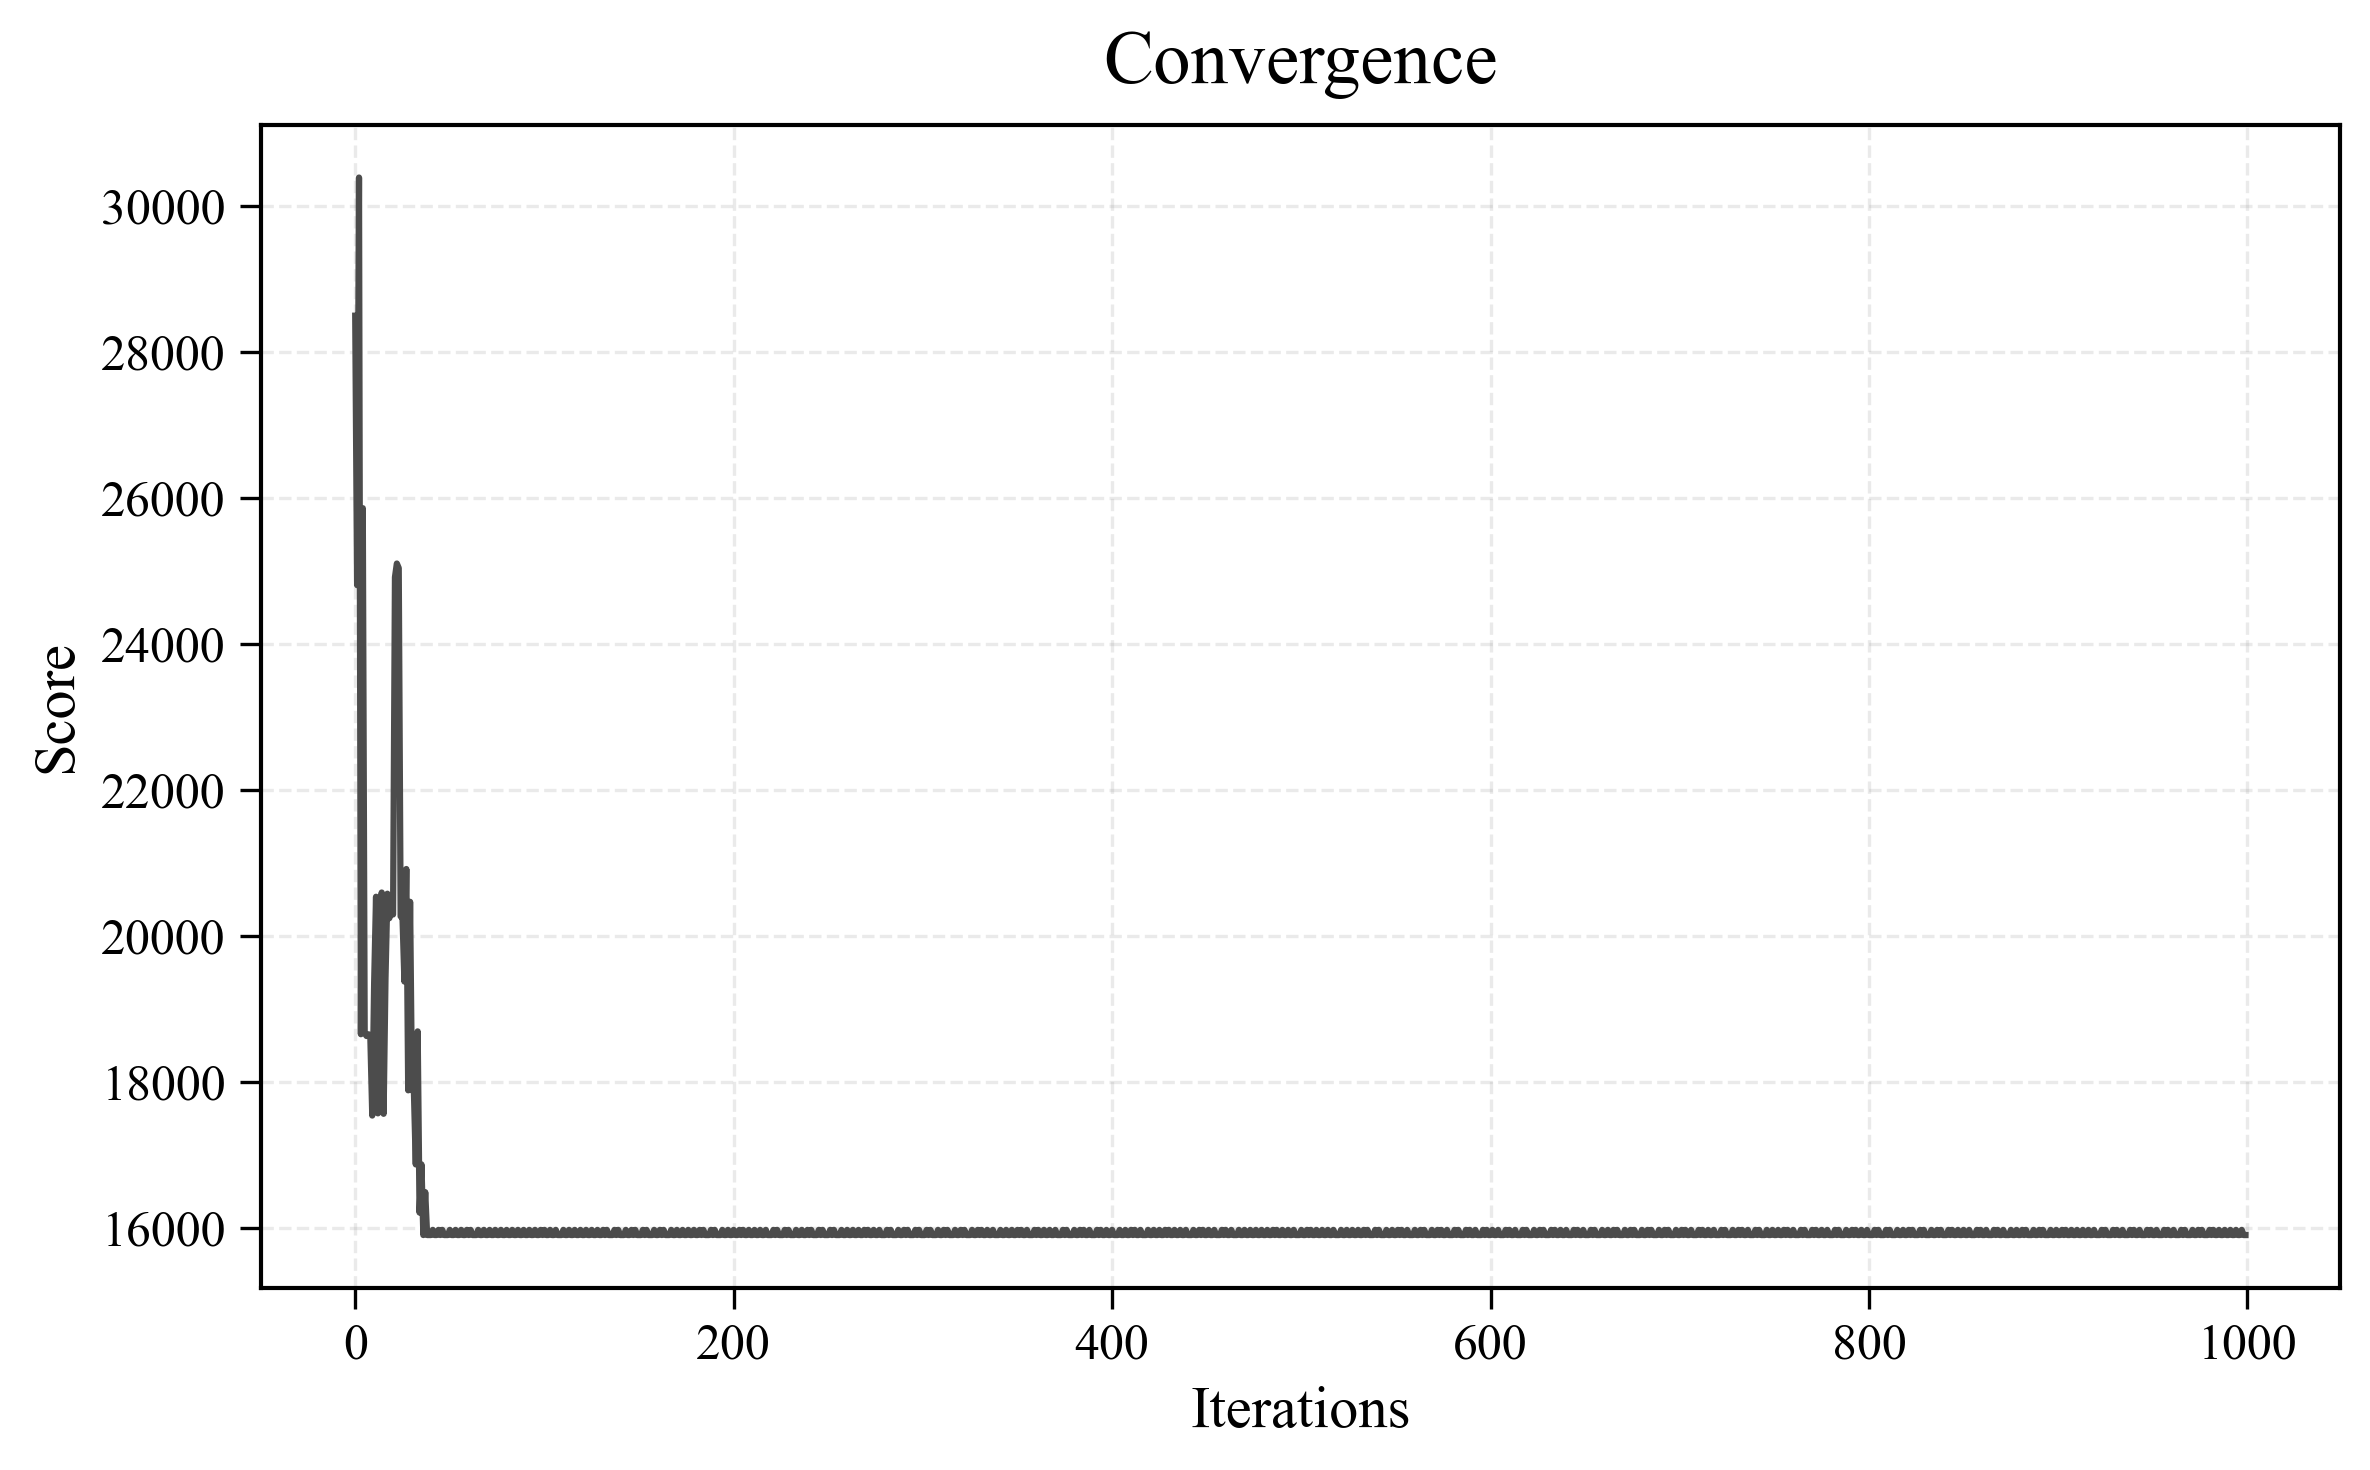

In [41]:
def plot_convergence(
    df,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5
):
    # 1) Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 2) Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        df.index,
        df['score'],
        color=color,
        linestyle=linestyle,
        linewidth=linewidth
    )
    ax.set_title("Convergence", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel("Score", fontsize=label_fontsize)
    ax.grid(True)  # already styled via rcParams

    plt.tight_layout()
    plt.show()

plot_convergence(df)


In [42]:
print(df.columns)

Index(['id', 'score', 'total_ghosts', 'overall_ghost_rate',
       'event_avg_ghost_rate', 'clone_percentage', 'total_tracks', 'time',
       'scatter', 'min_strong_track_length', 'allowed_missed_modules'],
      dtype='object')


In [43]:
print(max(df.score))
print(min(df.score))

30390.370216817326
15902.06334386093


In [44]:
def plot_expected_score_by_param(
    df,
    params=None,
    figsize=(8, 5),
    colors=None,
    linestyles=None,
    linewidths=None,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12,
    dpi=300,
    Title="INSERT",
    XAxis="INSERT"
):
    """
    Plot expected score (mean score) versus each hyperparameter in `params` with publication-quality styling.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    params : list[str], optional
        List of hyperparameter column names to plot. 
        If None, will use all columns except 'id' and 'score'.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    colors : list[str], optional
        Line colors for each parameter. Defaults to Tableau 10.
    linestyles : list[str], optional
        Line styles for each parameter. Defaults to solid lines.
    linewidths : list[float], optional
        Line widths for each parameter. Defaults to 1.5.
    title_fontsize, label_fontsize, tick_fontsize, legend_fontsize, dpi : int
        Matplotlib styling parameters.
    """
    if params is None:
        params = [c for c in df.columns if c not in ['id', 'score']]
    n = len(params)
    # Default style arrays
    if colors is None:
        gray_cmap = cm.get_cmap('Greys')
        gray_levels = np.linspace(0.3, 0.7, n)            # adjust range for contrast
        colors = [gray_cmap(g) for g in gray_levels]
        print(colors)
    if linestyles is None:
        linestyles = ['-'] * n
    if linewidths is None:
        linewidths = [1.5] * n

    # 1) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    means = df.groupby(params)['score'].mean()
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        means.index, 
        means.values,
        label=f'Expected Score',
        color=colors[0],
        linestyle=linestyles[0],
        linewidth=linewidths[0]
    )
    ax.set_title(Title, pad=10)
    ax.set_xlabel(XAxis, fontsize=label_fontsize)
    ax.set_ylabel('Expected Score', fontsize=label_fontsize)
    # If many unique values, rotate xticks
    if len(means.index) > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


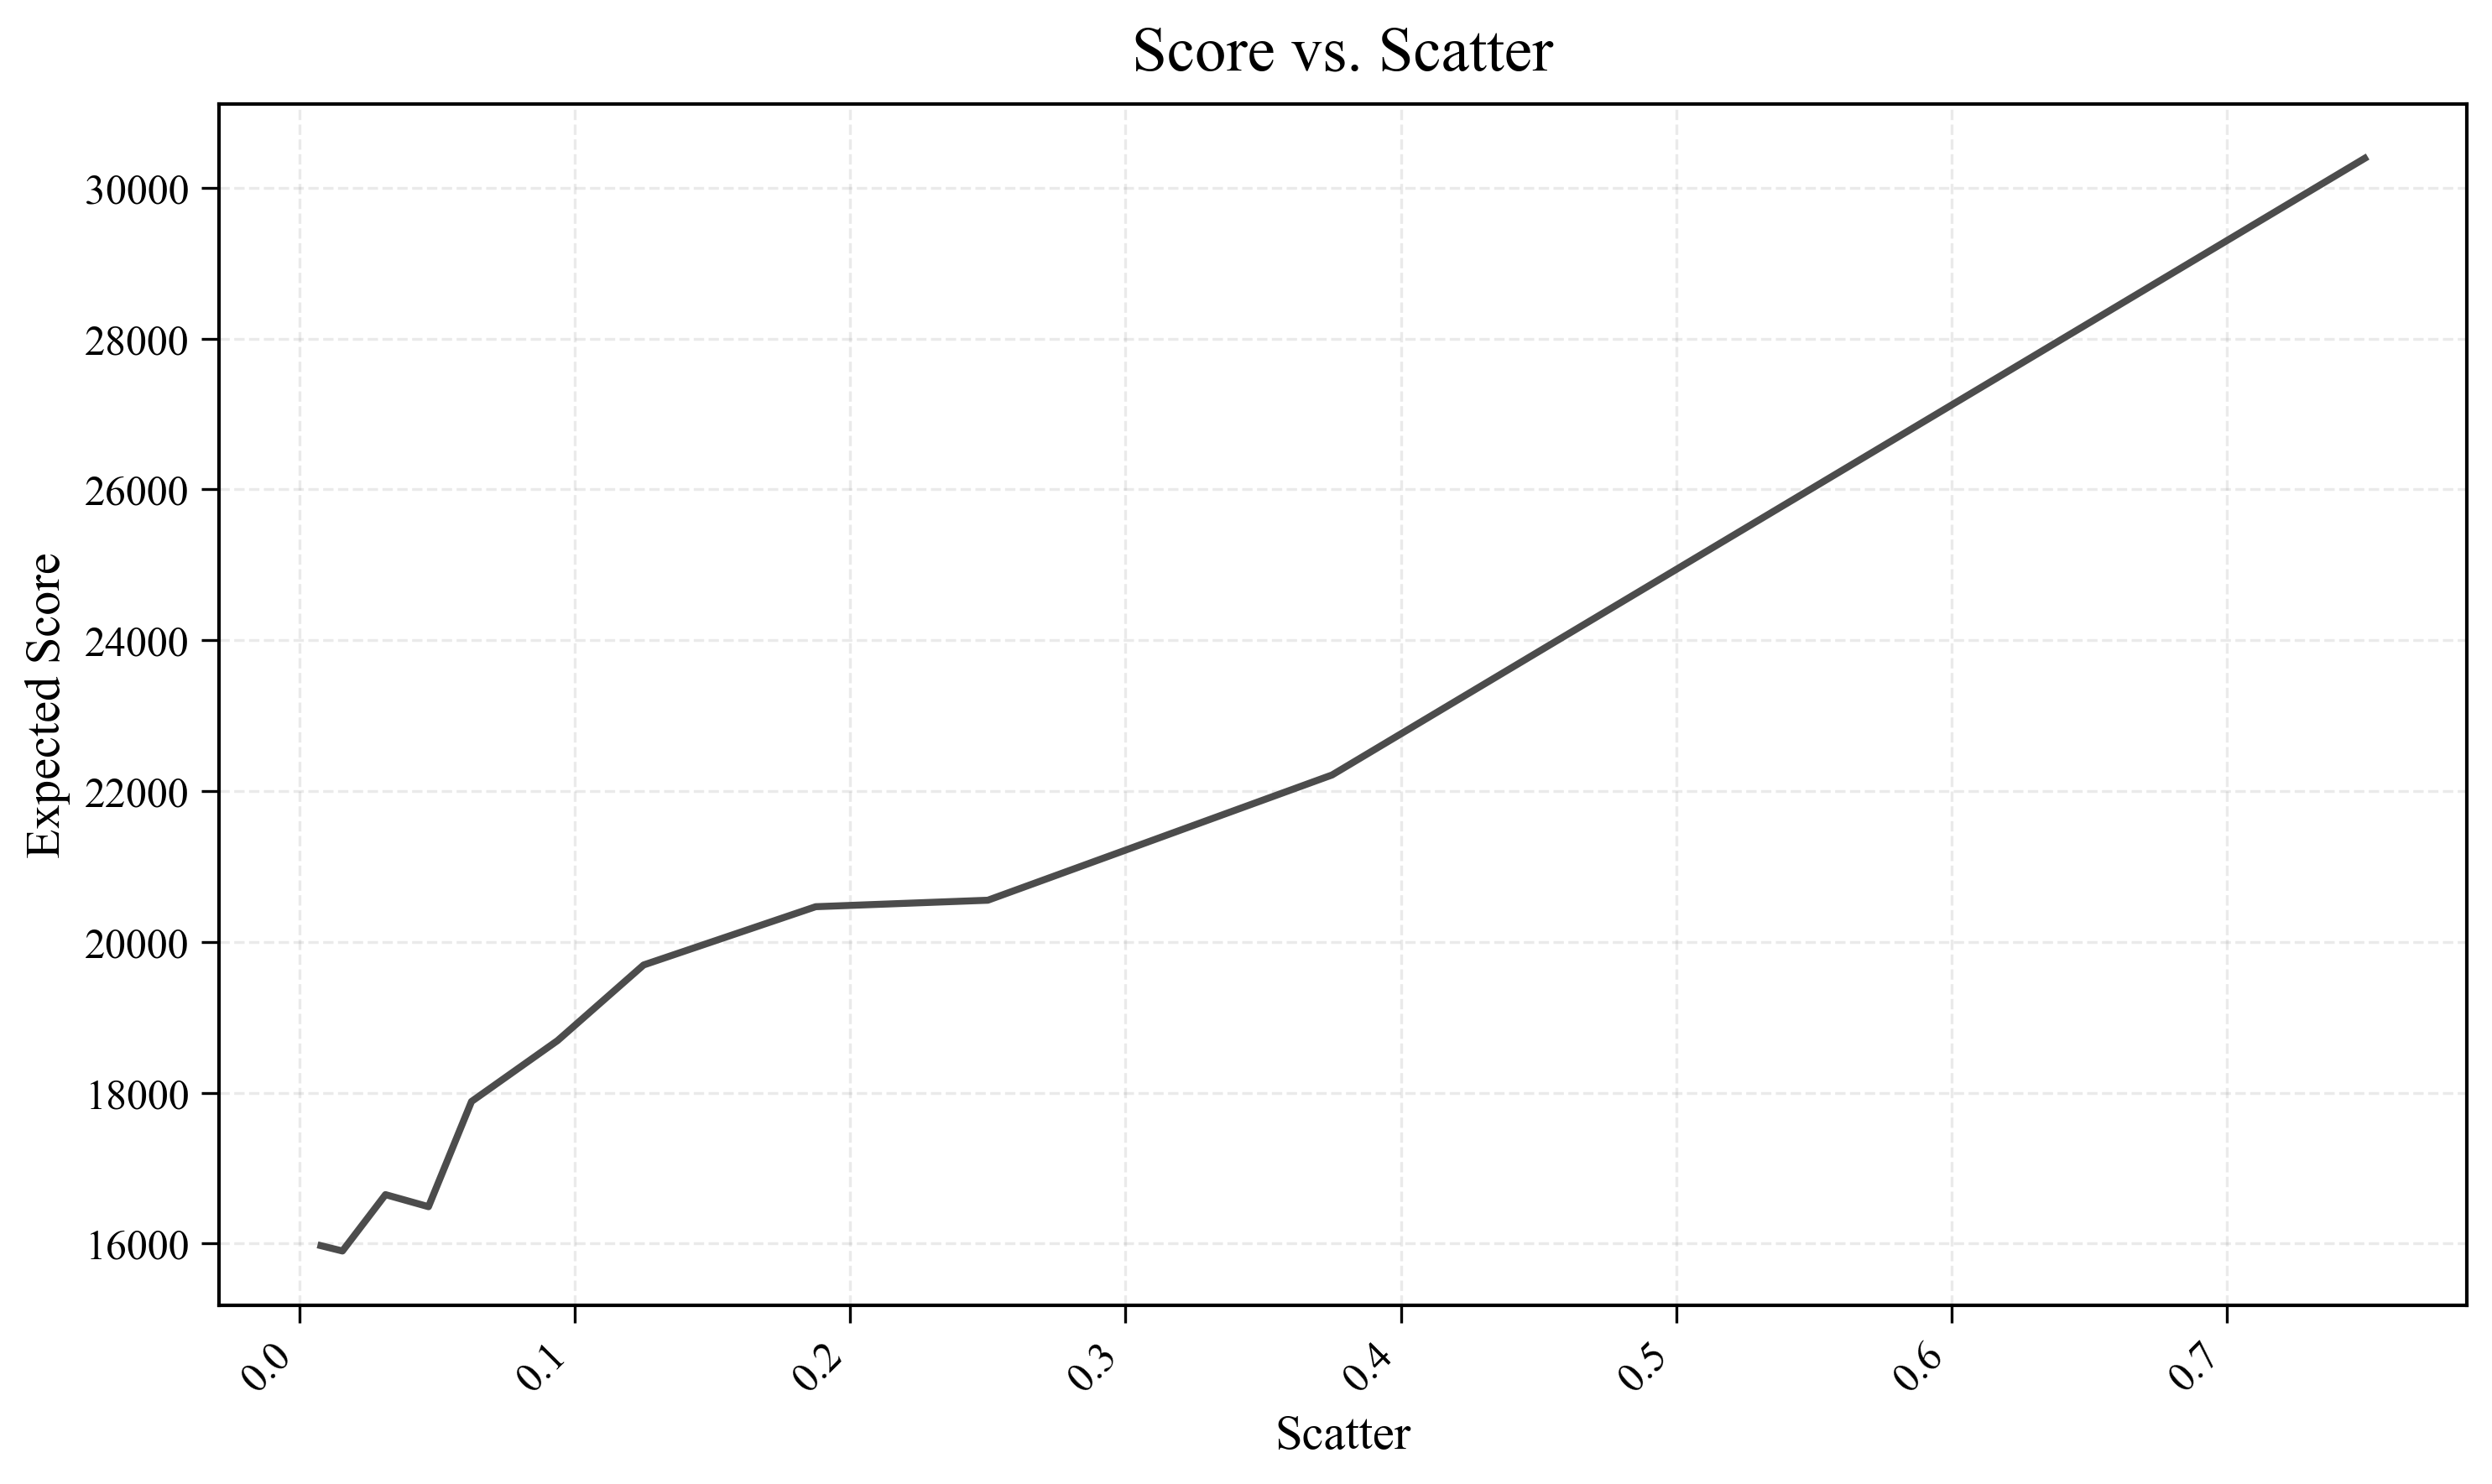

In [45]:
plot_expected_score_by_param(
    df,
    params='scatter',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Scatter",
    XAxis="Scatter"
)

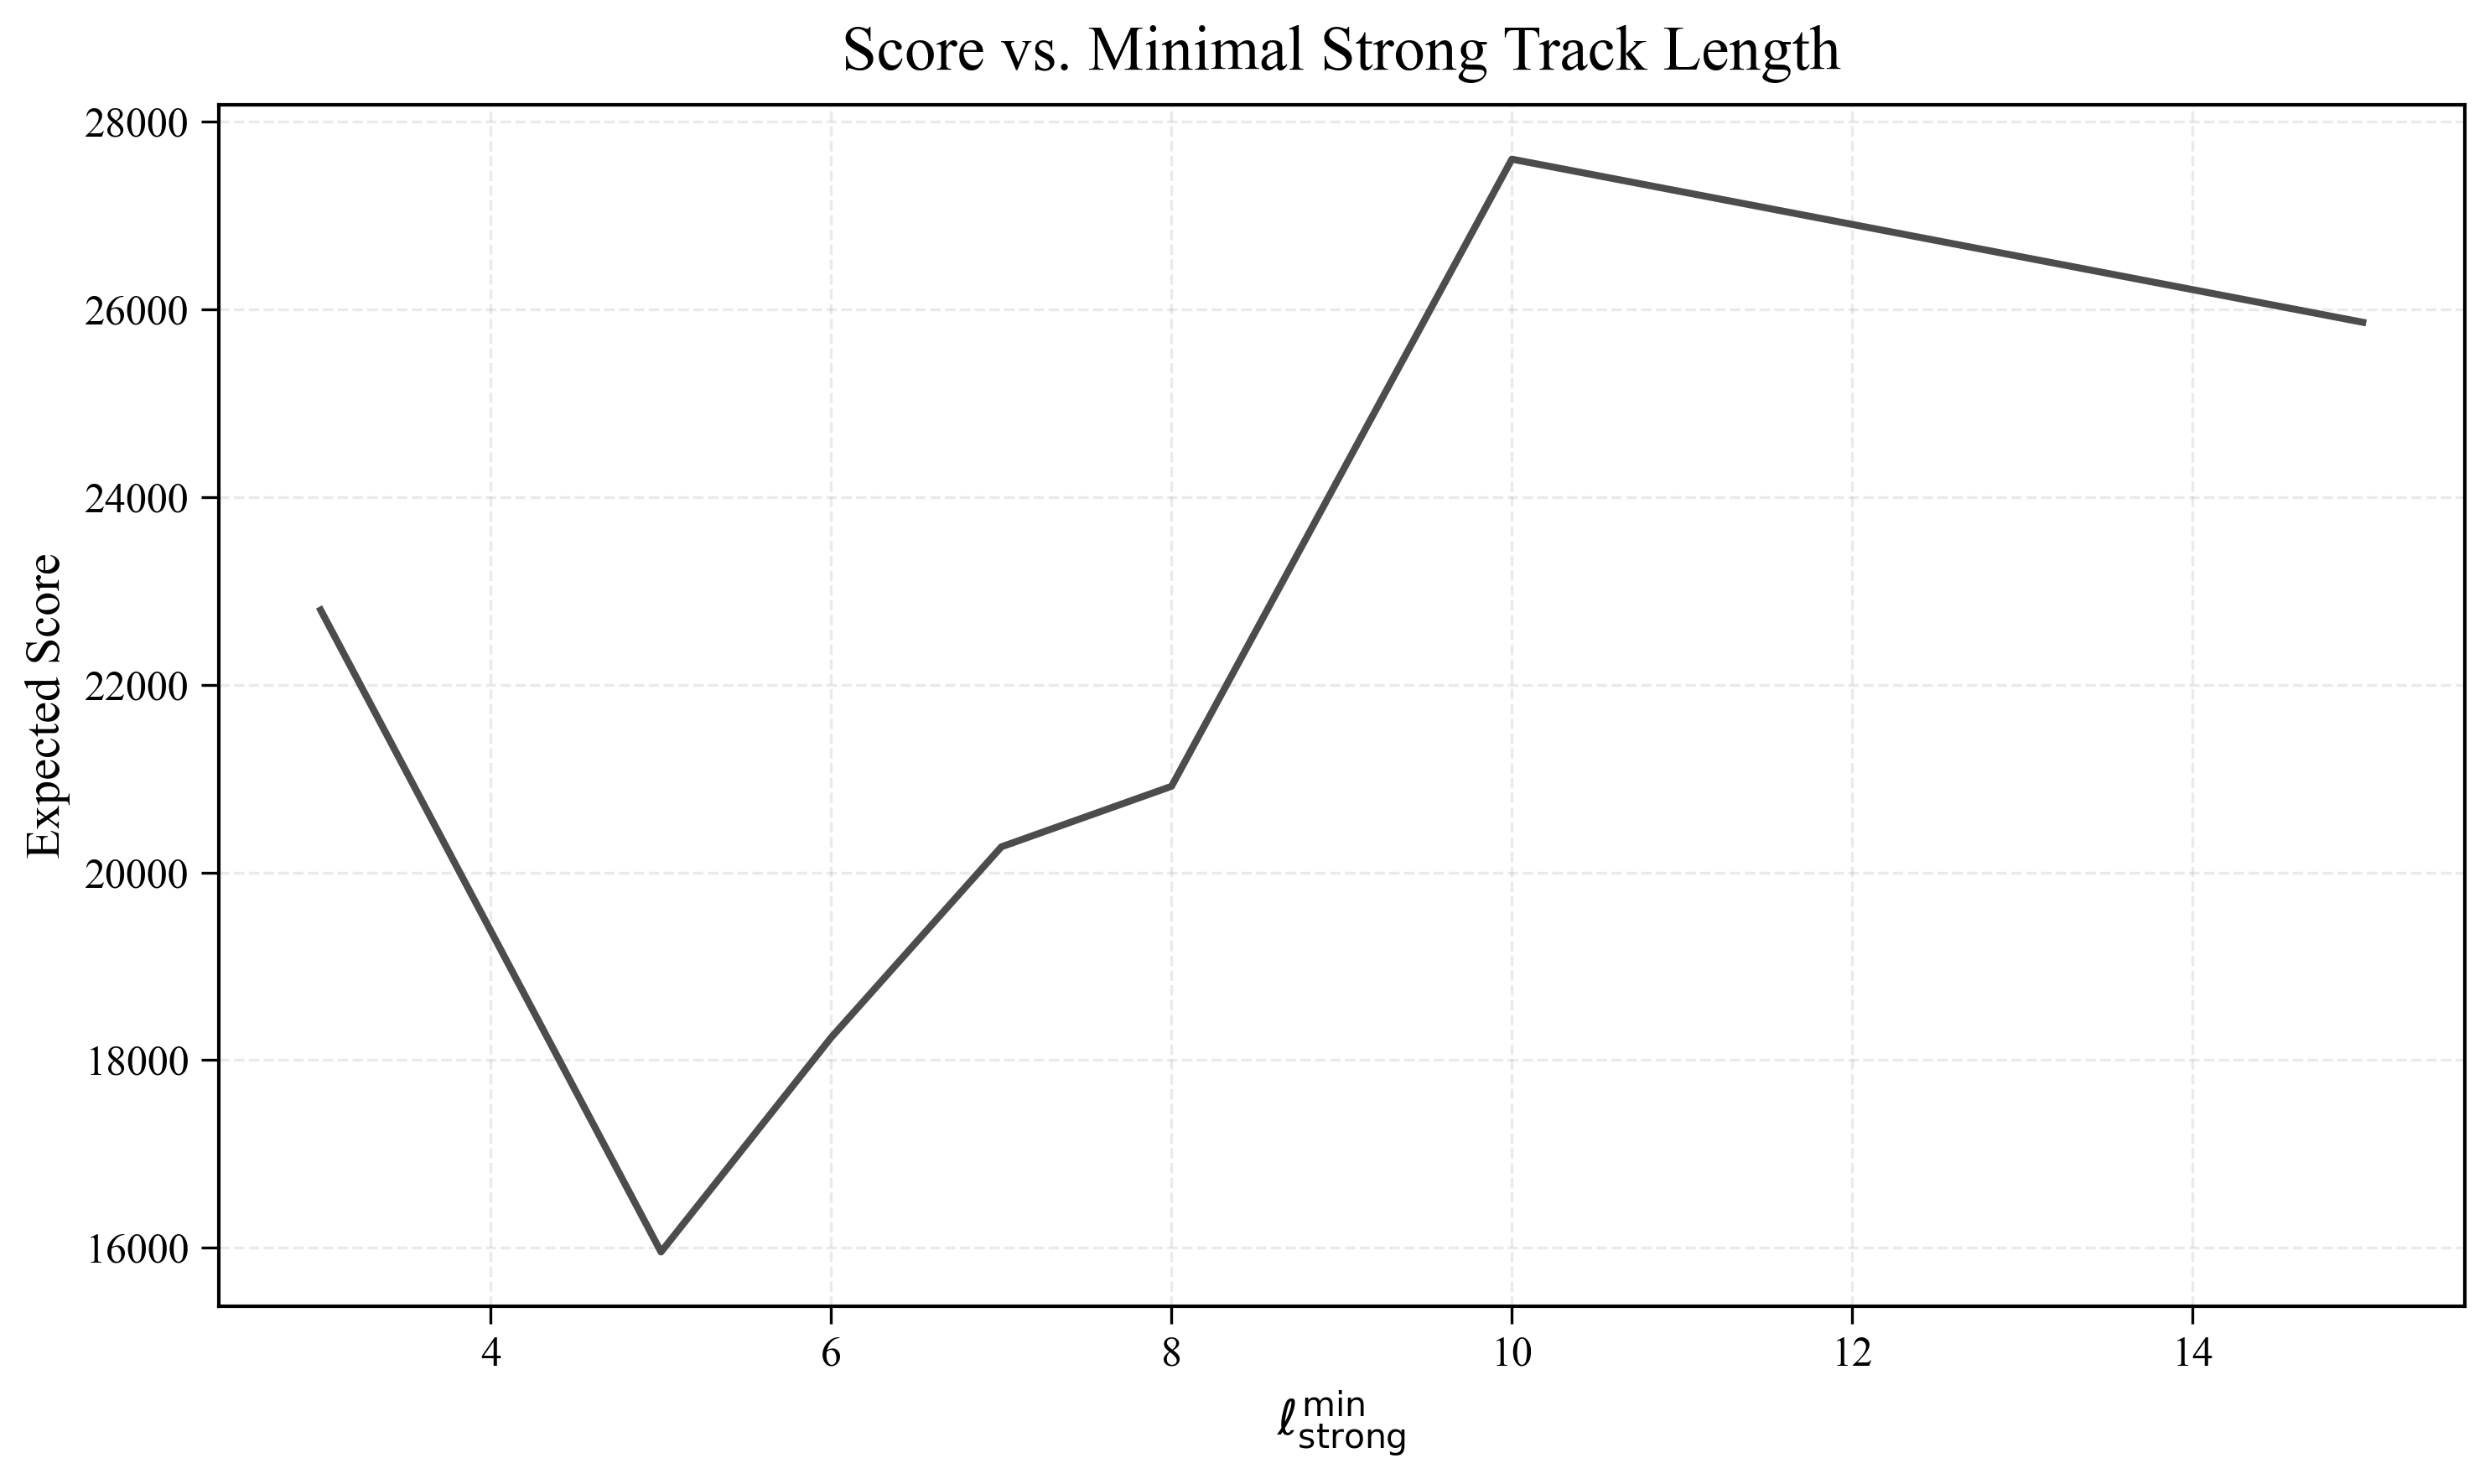

In [46]:
plot_expected_score_by_param(
    df,
    params='min_strong_track_length',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Minimal Strong Track Length",
    XAxis=r"$\ell_{\mathrm{strong}}^{\min}$"
)

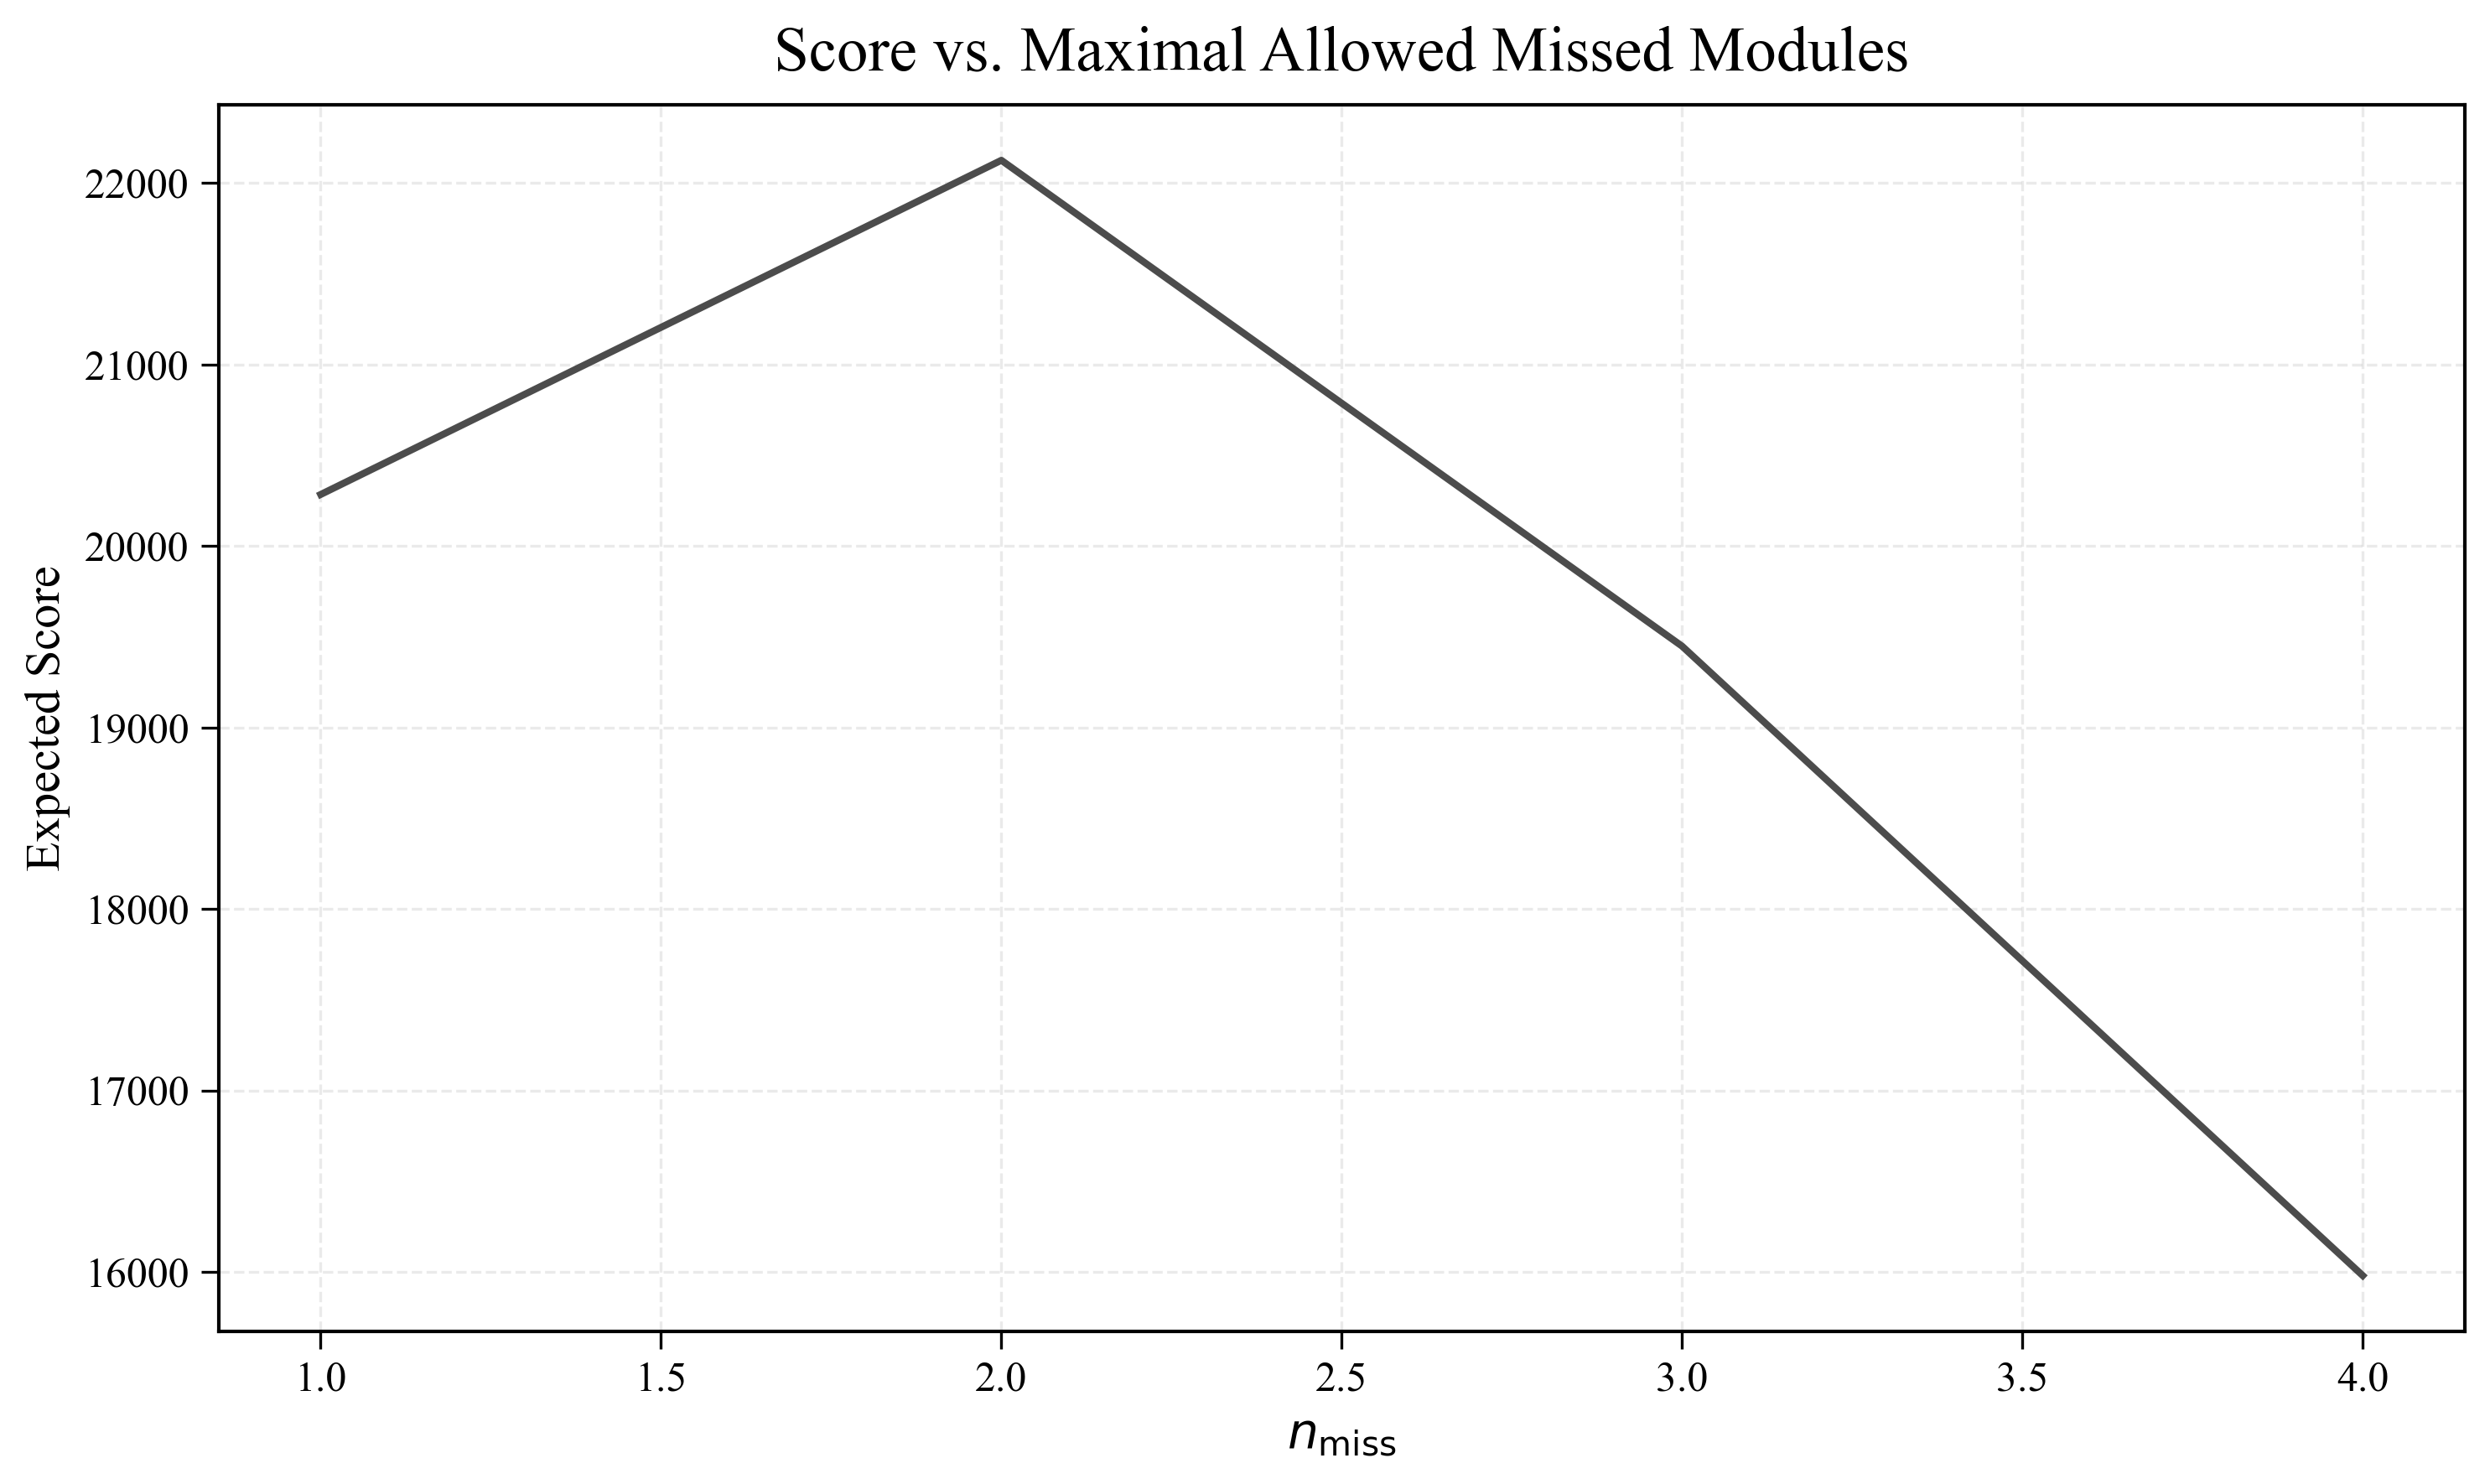

In [47]:
plot_expected_score_by_param(
    df,
    params='allowed_missed_modules',
    figsize=(10,6),
    colors=['#4C4C4C'],
    linestyles=['-','--'],
    linewidths=[2,2],
    Title="Score vs. Maximal Allowed Missed Modules",
    XAxis=r"$n_{\mathrm{miss}}$"
)

## Print the best set of params

In [48]:
df[df['score'] == df['score'].max()]

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules
2,278dc6be-8616-4e32-8a16-3a0f991c8dc9,30390.370217,31005,51.037037,44.848912,2.61183,60750,0.591057,0.75,10.0,2.0


# Plot hit map

In [49]:
def plot_score_scatter_by_params(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT"
):
    """
    Scatter plot of score as color vs two hyperparameters.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    x_param : str
        Column name for x-axis.
    y_param : str
        Column name for y-axis.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    cmap : str or Colormap, default='viridis'
        Colormap for score values.
    marker : str, default='o'
        Marker style.
    alpha : float, default=0.8
        Alpha blending for markers.
    title_fontsize, label_fontsize, tick_fontsize, dpi : int
        Matplotlib styling parameters.
    cbar_label : str, default='Score'
        Label for the colorbar.
    """
    # Configure rcParams for publication-quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    sc = ax.scatter(
        df[x_param],
        df[y_param],
        c=df['score'],
        cmap=cmap,
        marker=marker,
        alpha=alpha
    )
    ax.set_title(title, pad=10)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(cbar_label)

    # Rotate tick labels if needed
    if df[x_param].nunique() > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if df[y_param].nunique() > 10:
        plt.setp(ax.get_yticklabels(), rotation=45, va='top')

    plt.tight_layout()
    plt.show()



KeyError: 'max_slope_x'

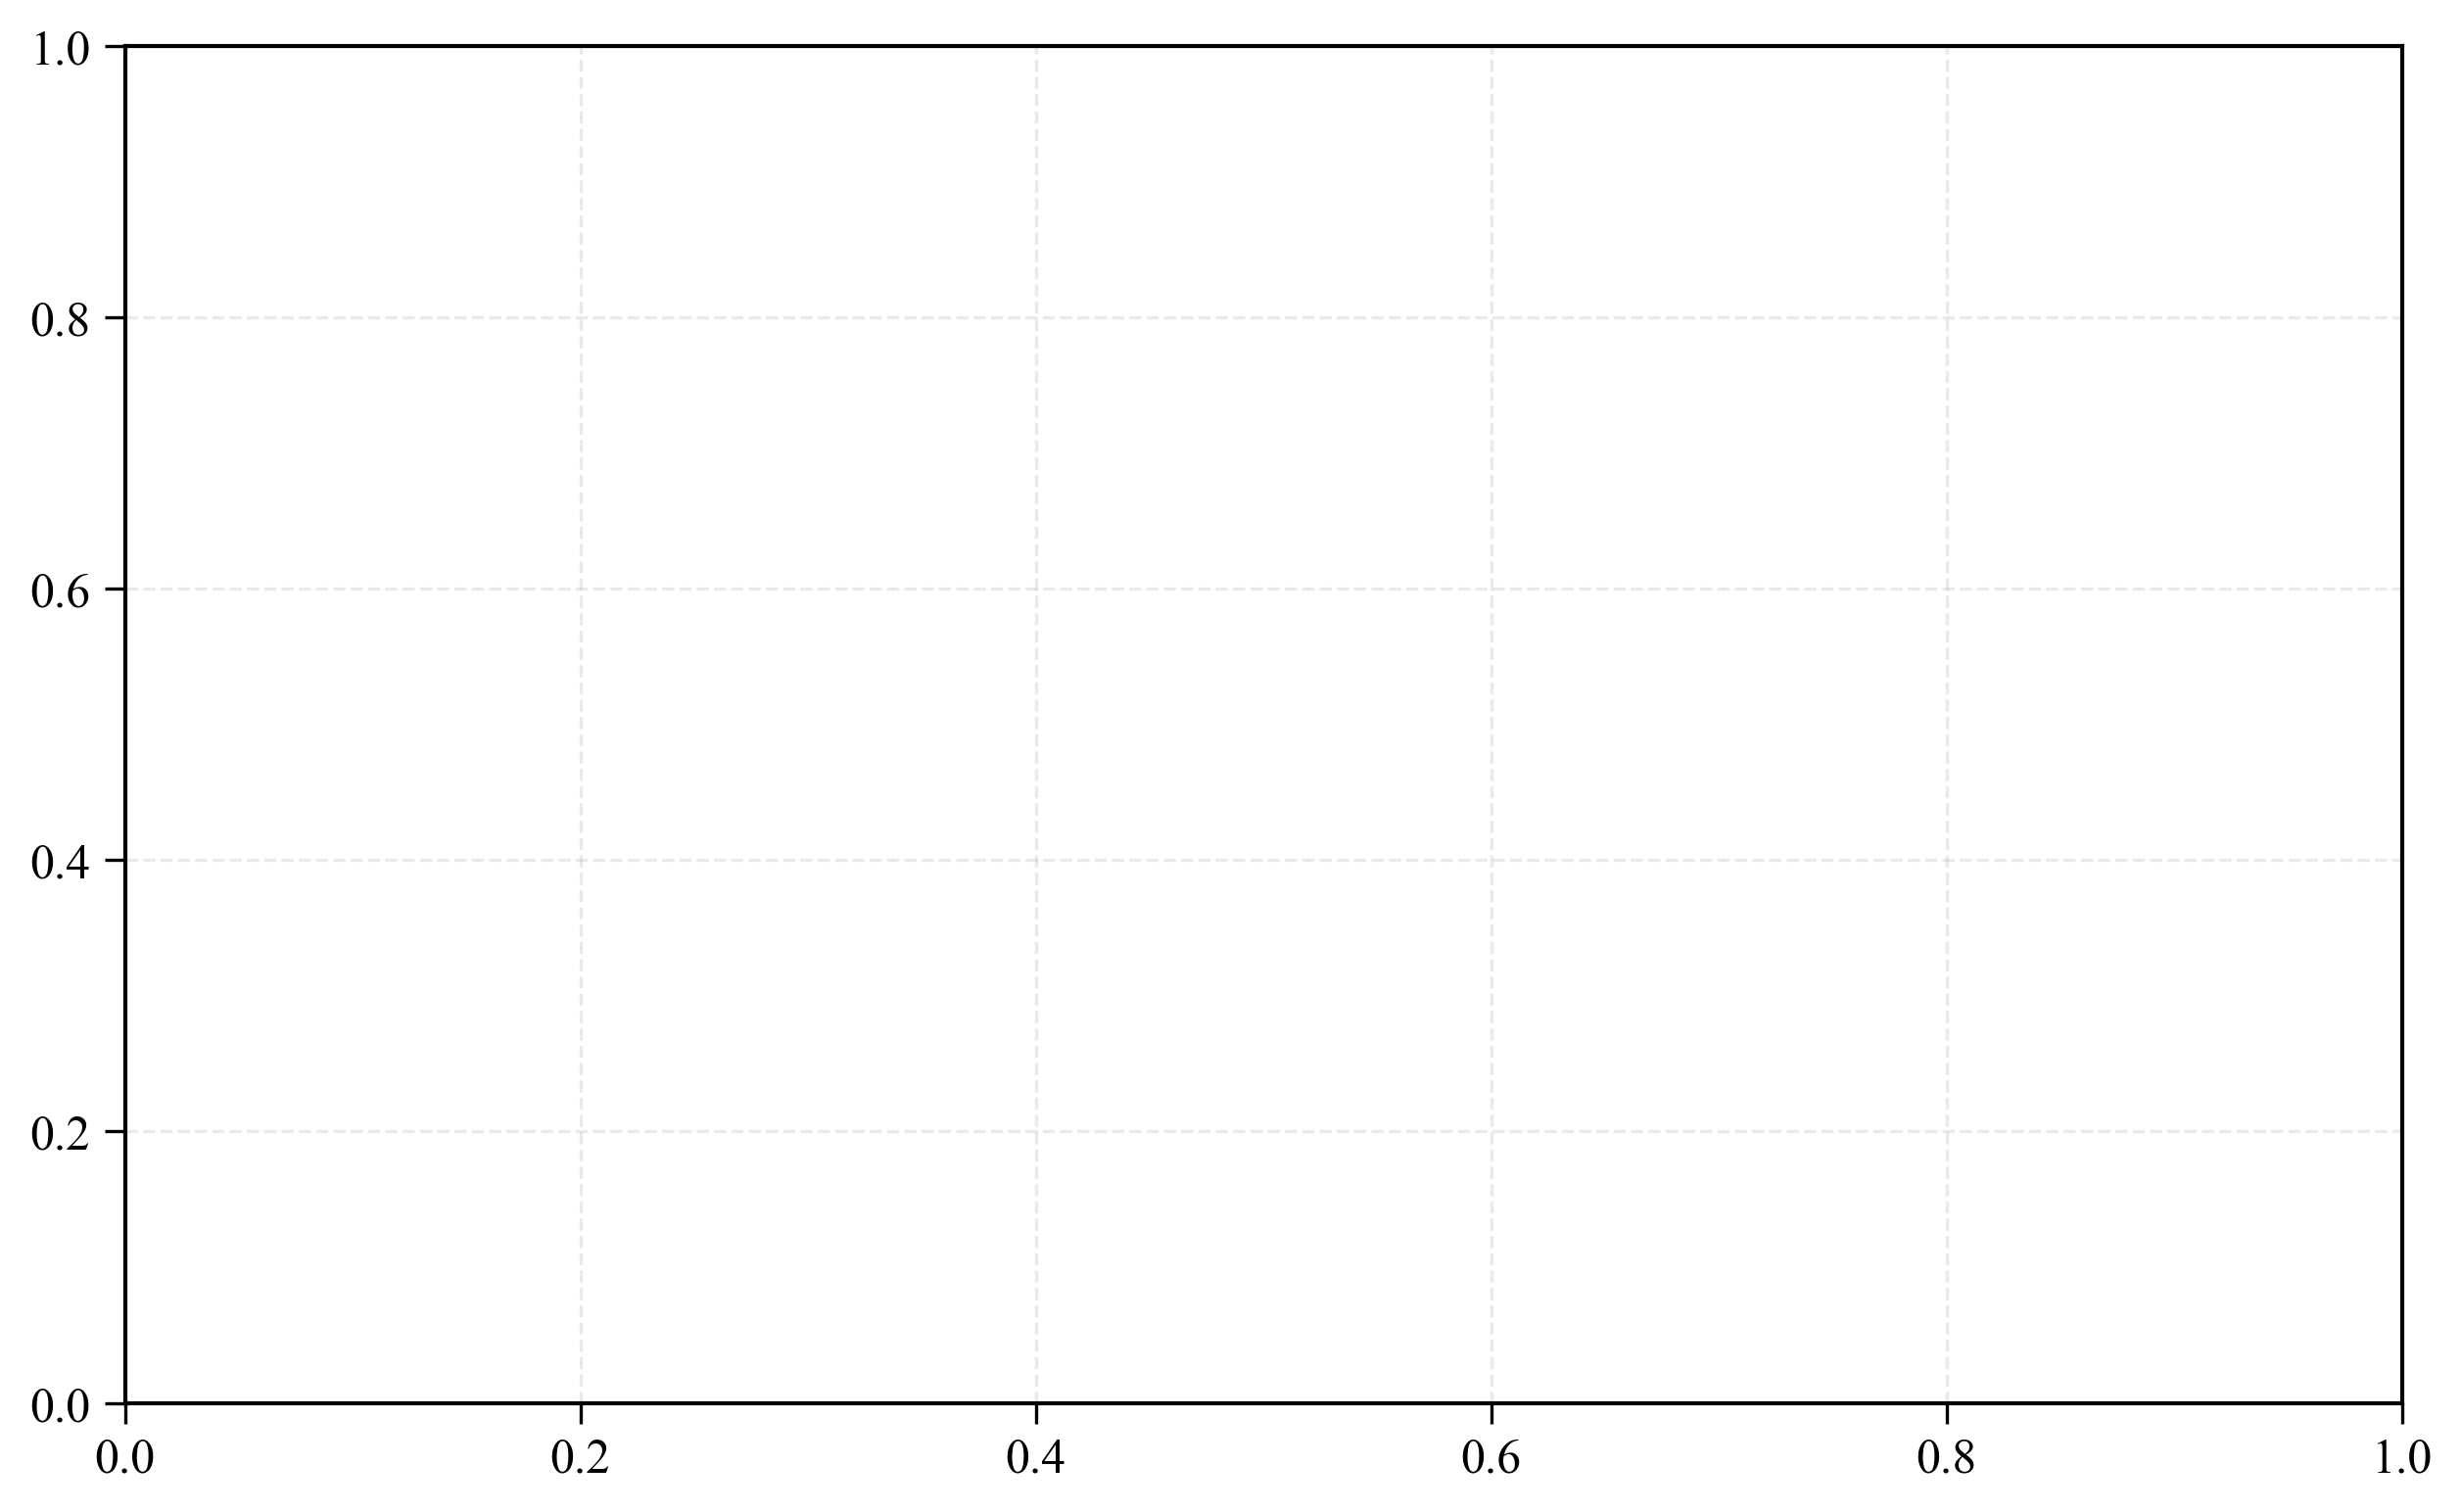

In [50]:
plot_score_scatter_by_params(
    df,
    x_param='max_slope_x',
    y_param='max_slope_y',
    figsize=(10, 6),
    cmap='plasma',
    marker='s',
    alpha=0.7,
    cbar_label='Mean Score',
    title="Score by Slope",
    XTitle="Max X Slope",
    YTitle="Max Y Slope"
)

## calculate the time of each run

In [ ]:
weigths = configuration["optimizer"]["weights"]

terms = (time_rate, clone_rate, ghost_rate, num_tracks)


NameError: name 'time_rate' is not defined

# TODO

* Estimate runtime for the objective func and the weights